In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os

In [45]:
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import nn, optim

In [46]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

### Loading Data

In [47]:
from PIL import Image

def get_data_loader(image_type, image_dir='/content/drive/MyDrive/ColabNotebooks/dataSet', image_size=128, batch_size=16, num_workers=0):
    """returns: training and test data loaders for a given image type, either summer or winter"""

    # Resize and normalize the images
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size), interpolation=Image.BICUBIC),  # Resize images to have dimensions (image_size, image_size)
        transforms.ToTensor()  # Convert images to PyTorch tensors
    ])

    # Get training and test directories
    train_path = os.path.join(image_dir, image_type)
    test_path = os.path.join(image_dir, 'test_{}'.format(image_type))

    # Define datasets using ImageFolder
    train_dataset = datasets.ImageFolder(train_path, transform)
    test_dataset = datasets.ImageFolder(test_path, transform)

    # Create and return DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    # Retrieve a sample image from the training dataset for visualization
    sample_image, _ = train_dataset[2]


    # Visualize the sample image

    # Display the raw image and transformed image side by side
    plt.figure(figsize=(12, 8))

    plt.subplot(1, 5, 2)
    plt.imshow(sample_image.permute(1, 2, 0))
    plt.title('Original Image')
    plt.axis('off')

    # Display the transformed image
    plt.subplot(1, 5, 4)
    np_image = sample_image.numpy().transpose((1, 2, 0))
    plt.imshow(np_image)
    plt.title('Transformed Image')
    plt.axis('off')

    plt.show()

    return train_loader, test_loader


####Resize and Normalize Output Check

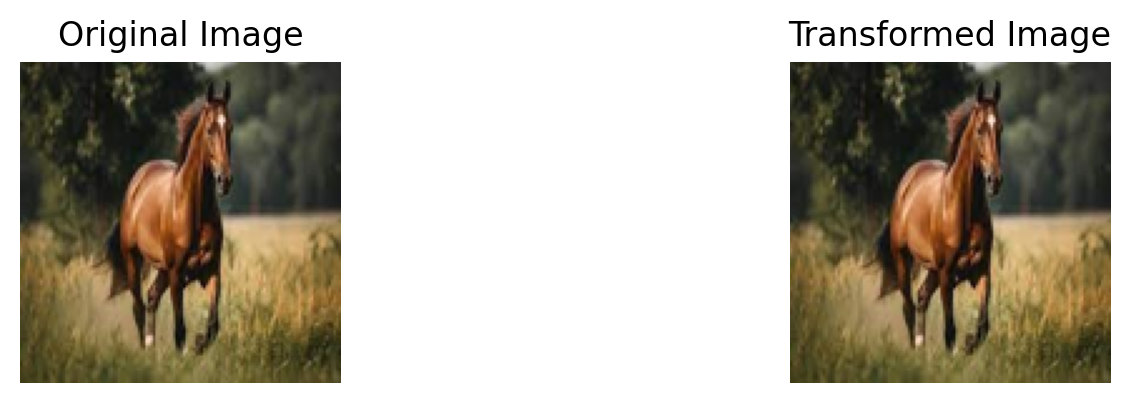

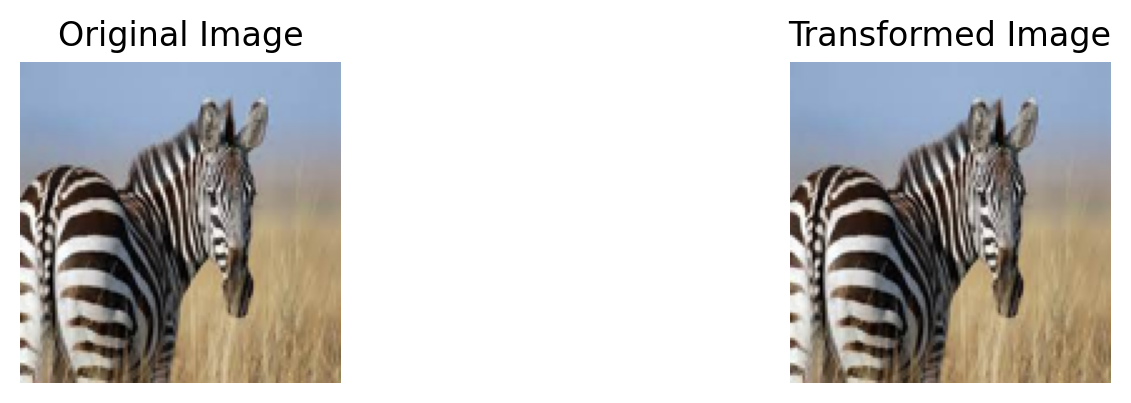

In [48]:
dataloader_X, test_dataloader_X = get_data_loader(image_type='hourse')
dataloader_Y, test_dataloader_Y = get_data_loader(image_type='zebra')

In [49]:
# display sample images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

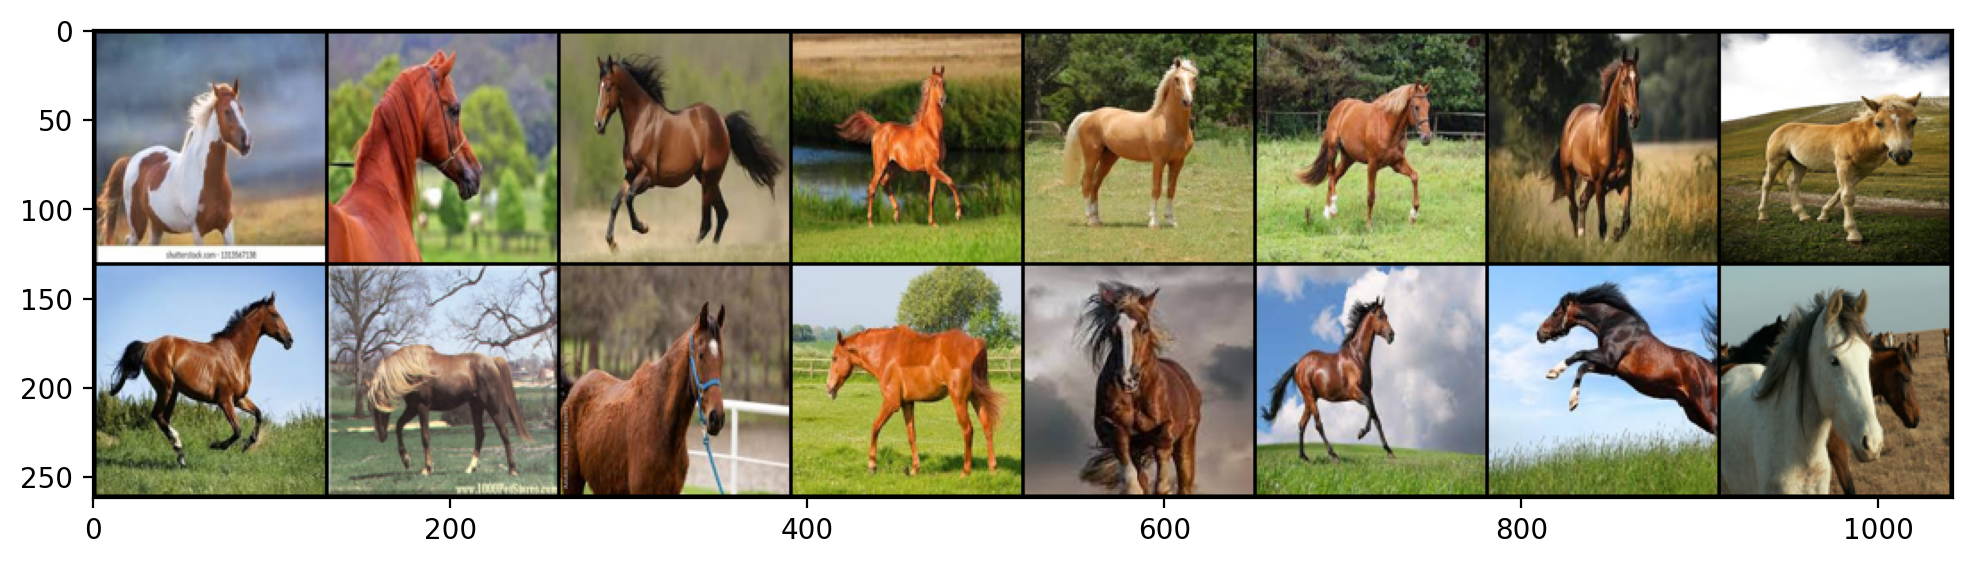

In [50]:
import torch
import torchvision
import matplotlib.pyplot as plt

# Assuming dataloader_X is your DataLoader
dataiter = iter(dataloader_X)
images, _ = next(dataiter)  # Use next() directly to get the next batch

# Visualize the batch of images
fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(images))
plt.show()

In [51]:
import torch
import torchvision
import matplotlib.pyplot as plt

# Assuming dataloader_Y is your DataLoader
dataiter = iter(dataloader_Y)

# Get the first batch from the dataloader
for images, _ in dataiter:
    break

# Visualize the batch of images
fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(images))
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### Building the Model


In [52]:
img = images[2]
print('min: ', img.min())
print('max: ', img.max())

min:  tensor(0.)
max:  tensor(1.)


In [53]:
# Define a helper function for creating convolutional layers
def conv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(conv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

#### Discriminator

In [54]:
# Discriminator Class
class Discriminator(nn.Module):
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()
        # Define all convolutional layers
        self.conv1 = conv(3, conv_dim, 4, stride=2, padding=1, batch_norm=False)  # 64x64x64
        self.conv2 = conv(conv_dim, conv_dim * 2, 4, stride=2, padding=1)  # 32x32x128
        self.conv3 = conv(conv_dim * 2, conv_dim * 4, 4, stride=2, padding=1)  # 16x16x256
        self.conv4 = conv(conv_dim * 4, conv_dim * 8, 4, stride=2, padding=1)  # 8x8x512
        # Final layer
        self.conv5 = nn.Conv2d(conv_dim * 8, 1, 4, stride=1, padding=0, bias=False)  # 1x1x1

    def forward(self, x):
        out = nn.ReLU()(self.conv1(x))
        out = nn.ReLU()(self.conv2(out))
        out = nn.ReLU()(self.conv3(out))
        out = nn.ReLU()(self.conv4(out))
        out = self.conv5(out)
        out = torch.sigmoid(out)  # Add sigmoid for output
        return out.view(-1)  # Flatten to 1D for output

In [55]:
# Residual block definition
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv(dim, dim, kernel_size=3, stride=1, padding=1)
        self.conv2 = conv(dim, dim, kernel_size=3, stride=1, padding=1, batch_norm=False)

    def forward(self, x):
        residual = x
        x = nn.ReLU()(self.conv1(x))
        x = self.conv2(x)
        return x + residual  # Adding residual for skip connection

In [56]:
def deconv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    layers = []
    deconv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(deconv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

#### CycleGenerator

In [57]:
# CycleGenerator Class
class CycleGenerator(nn.Module):
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super(CycleGenerator, self).__init__()
        # 1. Encoder
        self.conv1 = conv(3, conv_dim, 4, stride=2, padding=1)  # 128x128 -> 64x64
        self.conv2 = conv(conv_dim, conv_dim * 2, 4, stride=2, padding=1)  # 64x64 -> 32x32
        self.conv3 = conv(conv_dim * 2, conv_dim * 4, 4, stride=2, padding=1)  # 32x32 -> 16x16

        # 2. Residual blocks
        res_layers = []
        for _ in range(n_res_blocks):
            res_layers.append(ResidualBlock(conv_dim * 4))
        self.res_blocks = nn.Sequential(*res_layers)

        # 3. Decoder
        self.deconv1 = deconv(conv_dim * 4, conv_dim * 2, 4, stride=2, padding=1)  # 16x16 -> 32x32
        self.deconv2 = deconv(conv_dim * 2, conv_dim, 4, stride=2, padding=1)  # 32x32 -> 64x64
        self.deconv3 = deconv(conv_dim, 3, 4, stride=2, padding=1, batch_norm=False)  # 64x64 -> 128x128

    def forward(self, x):
        """Transforms an image and returns it."""
        out = nn.ReLU()(self.conv1(x))
        out = nn.ReLU()(self.conv2(out))
        out = nn.ReLU()(self.conv3(out))
        out = self.res_blocks(out)
        out = nn.ReLU()(self.deconv1(out))
        out = nn.ReLU()(self.deconv2(out))
        # Apply tanh activation to the final output
        out = nn.Tanh()(self.deconv3(out))
        return out

### Complete Network



In [58]:
# Assuming CycleGenerator and Discriminator are defined elsewhere

def create_model(
    g_conv_dim=64,
    d_conv_dim=64,
    n_res_blocks=6,
    device=None
):
    """Builds and initializes generators and discriminators for CycleGAN."""
    # Assign the device if not provided
    if device is None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Instantiate generators
    G_XtoY = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks).to(device)
    G_YtoX = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks).to(device)

    # Instantiate discriminators
    D_X = Discriminator(conv_dim=d_conv_dim).to(device)
    D_Y = Discriminator(conv_dim=d_conv_dim).to(device)

    # Log the device information
    if device.type == "cuda":
        print(f"Models moved to GPU: {torch.cuda.get_device_name(device)}.")
    else:
        print("Models using CPU.")

    # Return the initialized models
    return G_XtoY, G_YtoX, D_X, D_Y


In [59]:
G_XtoY, G_YtoX, D_X, D_Y = create_model()

Models moved to GPU: Tesla T4.


In [60]:
def print_models(G_XtoY, G_YtoX, D_X, D_Y):
    """Prints model information for the generators and discriminators.
    """
    print("                     G_XtoY                    ")
    print("-----------------------------------------------")
    print(G_XtoY)
    print()

    print("                     G_YtoX                    ")
    print("-----------------------------------------------")
    print(G_YtoX)
    print()

    print("                      D_X                      ")
    print("-----------------------------------------------")
    print(D_X)
    print()

    print("                      D_Y                      ")
    print("-----------------------------------------------")
    print(D_Y)
    print()


# print all of the models
print_models(G_XtoY, G_YtoX, D_X, D_Y)

                     G_XtoY                    
-----------------------------------------------
CycleGenerator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
 

#### GANs loss

In [61]:
def real_mse_loss(D_out):
    # how close is the produced output from being "real"?
    return torch.mean((D_out-1)**2)

In [62]:
def fake_mse_loss(D_out):
    # how close is the produced output from being "fake"?
    return torch.mean(D_out**2)

In [63]:
def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    # calculate reconstruction loss
    # as absolute value difference between the real and reconstructed images
    reconstr_loss = torch.mean(torch.abs(real_im - reconstructed_im))
    # return weighted loss
    return lambda_weight*reconstr_loss

### Optimizers

In [64]:
# hyperparams for Adam optimizer
lr=0.0002
beta1=0.5
beta2=0.999 # default value

In [65]:
# Get generator parameters
g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())

In [66]:
# Create optimizers for the generators and discriminators
g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

### Helper functions

In [67]:
import pdb
import pickle
import argparse
import scipy
import scipy.misc

In [68]:
warnings.filterwarnings("ignore")

In [69]:
def checkpoint(iteration, G_XtoY, G_YtoX, D_X, D_Y, checkpoint_dir='/content/drive/MyDrive/ColabNotebooks/model_checkpoints'):
    """saves the parameters of both generators G_YtoX, G_XtoY and discriminators D_X, D_Y"""
    G_XtoY_path = os.path.join(checkpoint_dir, 'G_XtoY.pkl')
    G_YtoX_path = os.path.join(checkpoint_dir, 'G_YtoX.pkl')
    D_X_path = os.path.join(checkpoint_dir, 'D_X.pkl')
    D_Y_path = os.path.join(checkpoint_dir, 'D_Y.pkl')
    torch.save(G_XtoY.state_dict(), G_XtoY_path)
    torch.save(G_YtoX.state_dict(), G_YtoX_path)
    torch.save(D_X.state_dict(), D_X_path)
    torch.save(D_Y.state_dict(), D_Y_path)

In [70]:
import numpy as np

def merge_images(sources, targets, batch_size=16):
    """
    Merges source and target image batches into a single image for visualization.

    Args:
    - sources (numpy array): Source images of shape (B, C, H, W).
    - targets (numpy array): Target images of shape (B, C, H, W).
    - batch_size (int): Number of images in each batch.

    Returns:
    - merged (numpy array): Merged image with source and target pairs side-by-side.
    """
    # Check if batch_size matches the number of images
    if len(sources) != batch_size or len(targets) != batch_size:
        raise ValueError("Batch size does not match the number of images in sources or targets.")

    # Get height and width from source images
    _, channels, height, width = sources.shape

    # Calculate number of rows for the merged image (square layout)
    row = int(np.sqrt(batch_size))

    # Initialize an empty array for the merged image
    # This will contain source and target pairs side-by-side
    merged = np.zeros((channels, row * height, row * width * 2))

    # Loop through the batches to fill the merged array
    for idx, (source, target) in enumerate(zip(sources, targets)):
        # Determine row and column index for placement
        row_idx = idx // row
        col_idx = idx % row

        # Place the source and target images into the merged array
        merged[:, row_idx * height:(row_idx + 1) * height, (col_idx * 2) * width:(col_idx * 2 + 1) * width] = source
        merged[:, row_idx * height:(row_idx + 1) * height, (col_idx * 2 + 1) * width:(col_idx * 2 + 2) * width] = target

    # Transpose the merged array for the correct (H, W, C) format
    merged = merged.transpose(1, 2, 0)

    return merged


In [71]:
def to_data(x):
    """converts variable to numpy."""
    if torch.cuda.is_available():
        x = x.cpu()
    x = x.data.numpy()
    x = ((x +1)*255 / (2)).astype(np.uint8) # rescale to 0-255
    return x

In [72]:
import os
import imageio
def save_samples(iteration, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16, sample_dir='image_samples'):
    """saves samples from both generators X->Y and Y->X."""
    # move input data to correct device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    fake_X = G_YtoX(fixed_Y.to(device))
    fake_Y = G_XtoY(fixed_X.to(device))

    X, fake_X = to_data(fixed_X), to_data(fake_X)
    Y, fake_Y = to_data(fixed_Y), to_data(fake_Y)

    # Create directory if it doesn't exist
    os.makedirs(sample_dir, exist_ok=True)


    merged = merge_images(X, fake_Y, batch_size)
    merged = merged.astype(np.uint8)
    path = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    imageio.imwrite(path, merged)
    print('Saved {}'.format(path))

    merged = merge_images(Y, fake_X, batch_size)
    merged = merged.astype(np.uint8)
    path = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    imageio.imwrite(path, merged)
    print('Saved {}'.format(path))

In [73]:
import torch
import torchvision.transforms.functional as TF

# Define scale function
def scale(x):
    # Scale the input tensor x to the range [-1, 1]
    return TF.normalize(x, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])


### Training the Model

In [74]:
def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=100):
    print_every=10

    # keep track of losses over time
    losses = []

    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)

    # Get some fixed data from domains X and Y for sampling. These are images that are held
    # constant throughout training, that allow us to inspect the model's performance.
    fixed_X = next(test_iter_X)[0]
    fixed_Y = next(test_iter_Y)[0]
   # fixed_X = test_iter_X.next()[0]
   # fixed_Y = test_iter_Y.next()[0]
    fixed_X = scale(fixed_X) # make sure to scale to a range -1 to 1
    fixed_Y = scale(fixed_Y)

    # batches per epoch
    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    batches_per_epoch = min(len(iter_X), len(iter_Y))

    for epoch in range(1, n_epochs+1):
        # Reset iterators for each epoch
        if epoch % batches_per_epoch == 0:
            iter_X = iter(dataloader_X)
            iter_Y = iter(dataloader_Y)

        images_X, _ = next(iter_X)
        images_X = scale(images_X) # make sure to scale to a range -1 to 1
        images_Y, _ = next(iter_Y)
        images_Y = scale(images_Y)

        # move images to GPU if available (otherwise stay on CPU)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images_X = images_X.to(device)
        images_Y = images_Y.to(device)


        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================

        ##   First: D_X, real and fake loss components   ##

        # Train with real images
        d_x_optimizer.zero_grad()

        # 1. Compute the discriminator losses on real images
        out_x = D_X(images_X)
        D_X_real_loss = real_mse_loss(out_x)

        # Train with fake images

        # 2. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)

        # 3. Compute the fake loss for D_X
        out_x = D_X(fake_X)
        D_X_fake_loss = fake_mse_loss(out_x)


        # 4. Compute the total loss and perform backprop
        d_x_loss = D_X_real_loss + D_X_fake_loss
        d_x_loss.backward()
        d_x_optimizer.step()


        ##   Second: D_Y, real and fake loss components   ##

        # Train with real images
        d_y_optimizer.zero_grad()

        # 1. Compute the discriminator losses on real images
        out_y = D_Y(images_Y)
        D_Y_real_loss = real_mse_loss(out_y)

        # Train with fake images

        # 2. Generate fake images that look like domain Y based on real images in domain X
        fake_Y = G_XtoY(images_X)

        # 3. Compute the fake loss for D_Y
        out_y = D_Y(fake_Y)
        D_Y_fake_loss = fake_mse_loss(out_y)

        # 4. Compute the total loss and perform backprop
        d_y_loss = D_Y_real_loss + D_Y_fake_loss
        d_y_loss.backward()
        d_y_optimizer.step()


        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================

        ##    First: generate fake X images and reconstructed Y images    ##
        g_optimizer.zero_grad()

        # 1. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)

        # 2. Compute the generator loss based on domain X
        out_x = D_X(fake_X)
        g_YtoX_loss = real_mse_loss(out_x)

        # 3. Create a reconstructed y
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_Y = G_XtoY(fake_X)
        reconstructed_y_loss = cycle_consistency_loss(images_Y, reconstructed_Y, lambda_weight=10)


        ##    Second: generate fake Y images and reconstructed X images    ##

        # 1. Generate fake images that look like domain Y based on real images in domain X
        fake_Y = G_XtoY(images_X)

        # 2. Compute the generator loss based on domain Y
        out_y = D_Y(fake_Y)
        g_XtoY_loss = real_mse_loss(out_y)

        # 3. Create a reconstructed x
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_X = G_YtoX(fake_Y)
        reconstructed_x_loss = cycle_consistency_loss(images_X, reconstructed_X, lambda_weight=10)

        # 5. Add up all generator and reconstructed losses and perform backprop
        g_total_loss = g_YtoX_loss + g_XtoY_loss + reconstructed_y_loss + reconstructed_x_loss
        g_total_loss.backward()
        g_optimizer.step()


        # Print the log info
        if epoch % print_every == 0:
            # append real and fake discriminator losses and the generator loss
            losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
                    epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))


        sample_every=100
        # Save the generated samples
        if epoch % sample_every == 0:
            G_YtoX.eval() # set generators to eval mode for sample generation
            G_XtoY.eval()
            save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16)
            G_YtoX.train()
            G_XtoY.train()

        # uncomment these lines, if you want to save your model
        checkpoint_every=1500
        # Save the model parameters
        if epoch % checkpoint_every == 0:
            checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)

    return losses


In [75]:

n_epochs = 5000
losses = training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=n_epochs)

Epoch [   10/ 5000] | d_X_loss: 0.1275 | d_Y_loss: 0.1733 | g_total_loss: 8.2928
Epoch [   20/ 5000] | d_X_loss: 0.1946 | d_Y_loss: 0.0785 | g_total_loss: 7.1166
Epoch [   30/ 5000] | d_X_loss: 0.1403 | d_Y_loss: 0.0195 | g_total_loss: 7.2684
Epoch [   40/ 5000] | d_X_loss: 0.3504 | d_Y_loss: 0.0252 | g_total_loss: 7.3430
Epoch [   50/ 5000] | d_X_loss: 0.0186 | d_Y_loss: 0.0099 | g_total_loss: 6.5989
Epoch [   60/ 5000] | d_X_loss: 0.1654 | d_Y_loss: 0.0232 | g_total_loss: 6.5002
Epoch [   70/ 5000] | d_X_loss: 0.0126 | d_Y_loss: 0.0081 | g_total_loss: 6.4714
Epoch [   80/ 5000] | d_X_loss: 0.0983 | d_Y_loss: 0.0985 | g_total_loss: 6.4444
Epoch [   90/ 5000] | d_X_loss: 0.2417 | d_Y_loss: 0.0857 | g_total_loss: 5.9014
Epoch [  100/ 5000] | d_X_loss: 0.0568 | d_Y_loss: 0.0047 | g_total_loss: 6.4664
Saved image_samples/sample-000100-X-Y.png
Saved image_samples/sample-000100-Y-X.png
Epoch [  110/ 5000] | d_X_loss: 0.0695 | d_Y_loss: 0.0207 | g_total_loss: 6.5211
Epoch [  120/ 5000] | d_X

#### Training and Loss Patterns

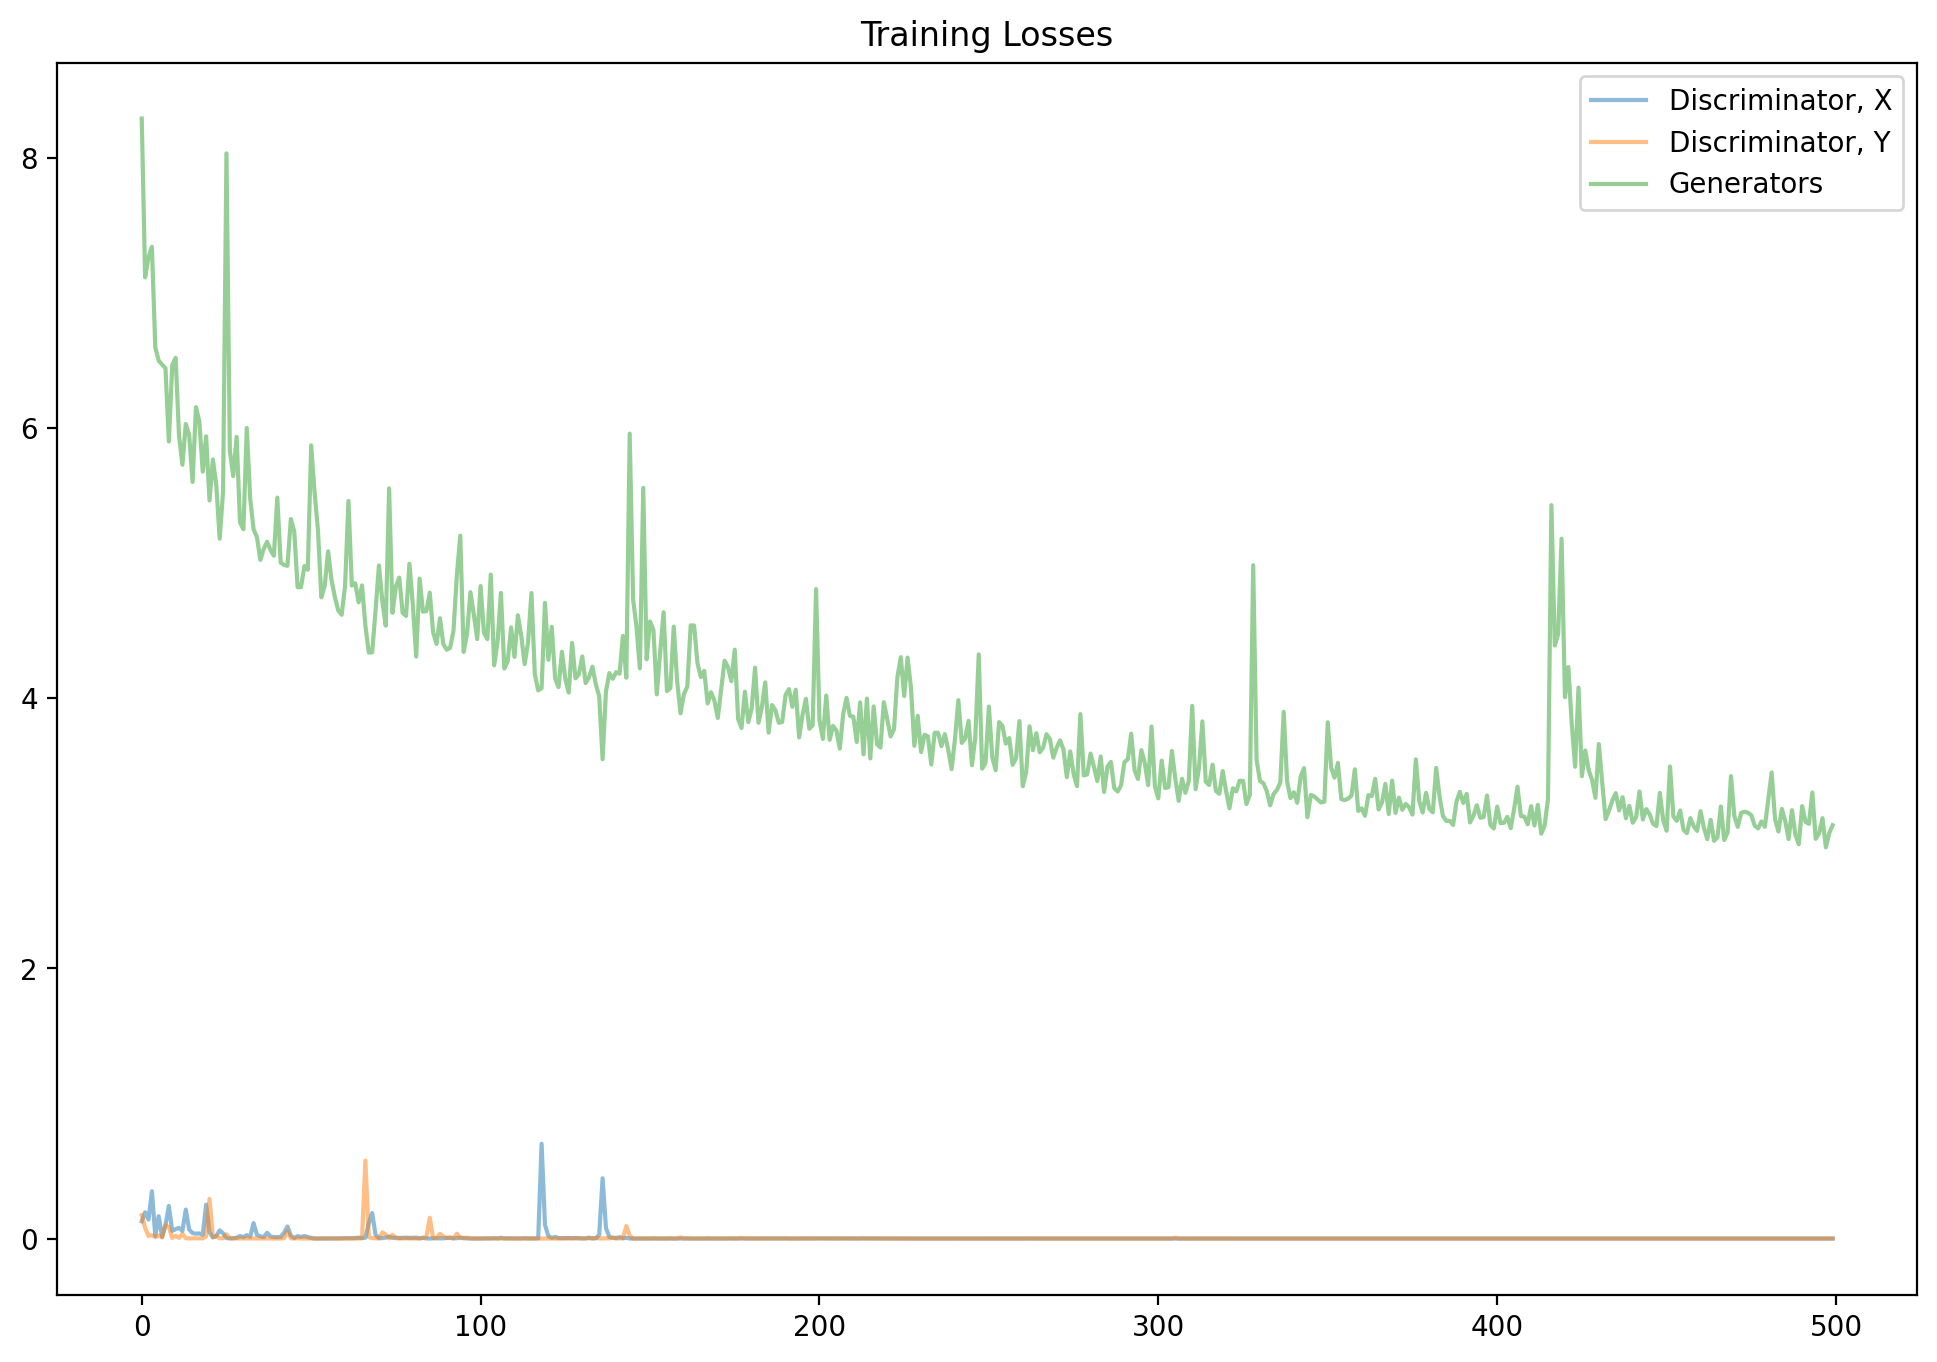

In [76]:
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Results

In [77]:
import matplotlib.image as mpimg

In [78]:
def view_samples(iteration, sample_dir='/content/image_samples'):
    # samples are named by iteration
    path_XtoY = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    path_YtoX = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))

    # read in those samples
    x2y, y2x = None, None
    try:
        x2y = mpimg.imread(path_XtoY)
        y2x = mpimg.imread(path_YtoX)
    except:
        print('Invalid number of iterations.')

    fig, (ax1, ax2) = plt.subplots(figsize=(18,20), nrows=2, ncols=1, sharey=True, sharex=True)
    ax1.imshow(x2y)
    ax1.set_title('X to Y')
    ax2.imshow(y2x)
    ax2.set_title('Y to X')

In [79]:
# view samples at iteration 100
view_samples(100)

Output hidden; open in https://colab.research.google.com to view.

In [80]:
# view samples at iteration 5000
view_samples(5000)